# Logistic regression

# Dataset Information

In [1]:
# Load dataset
#!pip3 install --upgrade oauth2client
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Please upload your csv on your google drive, give access to anyone, copy the link, and update the file ID and name.
google_docs = {
    '1ZhkHvU0bUYACMgnEnPDa61pdj1VC5F5y' : 'clean_store.csv',
    '1j7HOEKLZctvRBl14vtglzYYzT-PIsiJd' : 'tutorial7.py',
    '1bQhKWLDYYW3NYGxYfY506B6lJ7Mk9G6Y' : 'tutorial2.py'
}


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for key in google_docs:
  drive.CreateFile({'id':key}).GetContentFile(google_docs[key])

In [2]:
!pip install cartopy
!pip install catboost
!pip install optuna
!pip install category_encoders
#!pip install pygam==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Requirements 
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna
import sys

from sklearn.model_selection import train_test_split

from tutorial7 import plot_feature_importance

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'cartopy {cartopy.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {xgb.__version__}')
print(f'lightgbm {lgb.__version__}')
print(f'catboost {catboost.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on:

# numpy 1.23.5
# scipy 1.10.0
# pandas 1.5.2
# seaborn 0.12.2
# cartopy 0.21.1
# scikit-learn 1.2.0
# xgboost 1.6.1
# lightgbm 3.3.2
# catboost 1.0.6
# optuna 2.10.1


# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on


Package versions: 

numpy 1.22.4
scipy 1.10.1
pandas 1.5.3
seaborn 0.12.2
cartopy 0.21.1
scikit-learn 1.2.2
xgboost 1.7.5
lightgbm 3.3.5
catboost 1.2
optuna 3.1.1


In [4]:
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
%config InlineBackend.figure_format = 'retina'


In [5]:
#Without encoding
store = pd.read_csv('clean_store.csv')

index_train_v, index_test = train_test_split(store.index, train_size=0.7, random_state=7)


train_v = store.loc[index_train_v, :].copy()
test = store.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='resp'].copy()
X_valid = valid.loc[:, test.columns!='resp'].copy()
X_test = test.loc[:, test.columns!='resp'].copy()

predictors = list(X_train.columns)

y_train = train['resp']
y_valid = valid['resp']
y_test = test['resp']

In [6]:
nominal = list(X_train.columns[X_train.dtypes == "object"])
features = list(X_train.columns[X_train.dtypes != "object"])

In [7]:
store.head()

,zip_code,fre,mon,cc_card,avrg,pc_calc20,psweaters,pknit_tops,pknit_dres,pblouses,...,web,mailed,responded,responserate,hi,ltfreday,clustype,percret,resp,valphon_y
0,1001,2,368.46,0,184.23,11,0.18,0.00,0.00,0.30,...,0,5,0,0.00,31.81,111.00,10,0.00,0,0
1,1028,4,258.00,1,64.50,11,0.26,0.16,0.00,0.00,...,0,4,2,50.00,32.72,43.50,10,0.03,1,1
2,1056,2,77.00,0,38.50,11,1.00,0.00,0.00,0.00,...,0,4,0,0.00,100.00,68.60,16,0.00,0,0
3,1118,8,846.06,1,105.75,11,0.38,0.00,0.05,0.06,...,0,9,6,66.67,23.27,26.96,10,0.00,0,1
4,1107,1,87.44,0,87.44,11,0.20,0.20,0.00,0.00,...,0,0,0,0.00,28.52,24.50,20,0.00,0,1


In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21740 entries, 0 to 21739
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip_code      21740 non-null  int64  
 1   fre           21740 non-null  int64  
 2   mon           21740 non-null  float64
 3   cc_card       21740 non-null  int64  
 4   avrg          21740 non-null  float64
 5   pc_calc20     21740 non-null  int64  
 6   psweaters     21740 non-null  float64
 7   pknit_tops    21740 non-null  float64
 8   pknit_dres    21740 non-null  float64
 9   pblouses      21740 non-null  float64
 10  pjackets      21740 non-null  float64
 11  pcar_pnts     21740 non-null  float64
 12  pcas_pnts     21740 non-null  float64
 13  pshirts       21740 non-null  float64
 14  pdresses      21740 non-null  float64
 15  psuits        21740 non-null  float64
 16  pouterwear    21740 non-null  float64
 17  pjewelry      21740 non-null  float64
 18  pfashion      21740 non-nu

In [9]:
continuous = ['psweaters', 'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets',
              'pcar_pnts', 'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear',
              'pjewelry', 'pfashion', 'plegwear', 'pcollspnd', 'gmp', 'fredays',
              'markdown', 'ltfreday', 'percret', 'amspend', 'psspend', 'ccspend',
              'tmonspend', 'omonspend', 'smonspend', 'prevpd']

binary = ['responserate']

nominal = ['cc_card', 'valphon_y', 'web', 'mailed', 'responded', 'clustype']

discrete = ['avrg']

ordinal = ['classes', 'coupons', 'stores', 'styles', 'fre']

response = ['resp']

In [ ]:
variable = binary + nominal + ordinal



In [10]:
train['resp'].value_counts(normalize=True)

0    0.837016
1    0.162984
Name: resp, dtype: float64

In [ ]:
# X_train.info()

In [12]:
tau = 1/(1+9)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.1


# Logistic Regression Models

In [13]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none')
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [14]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

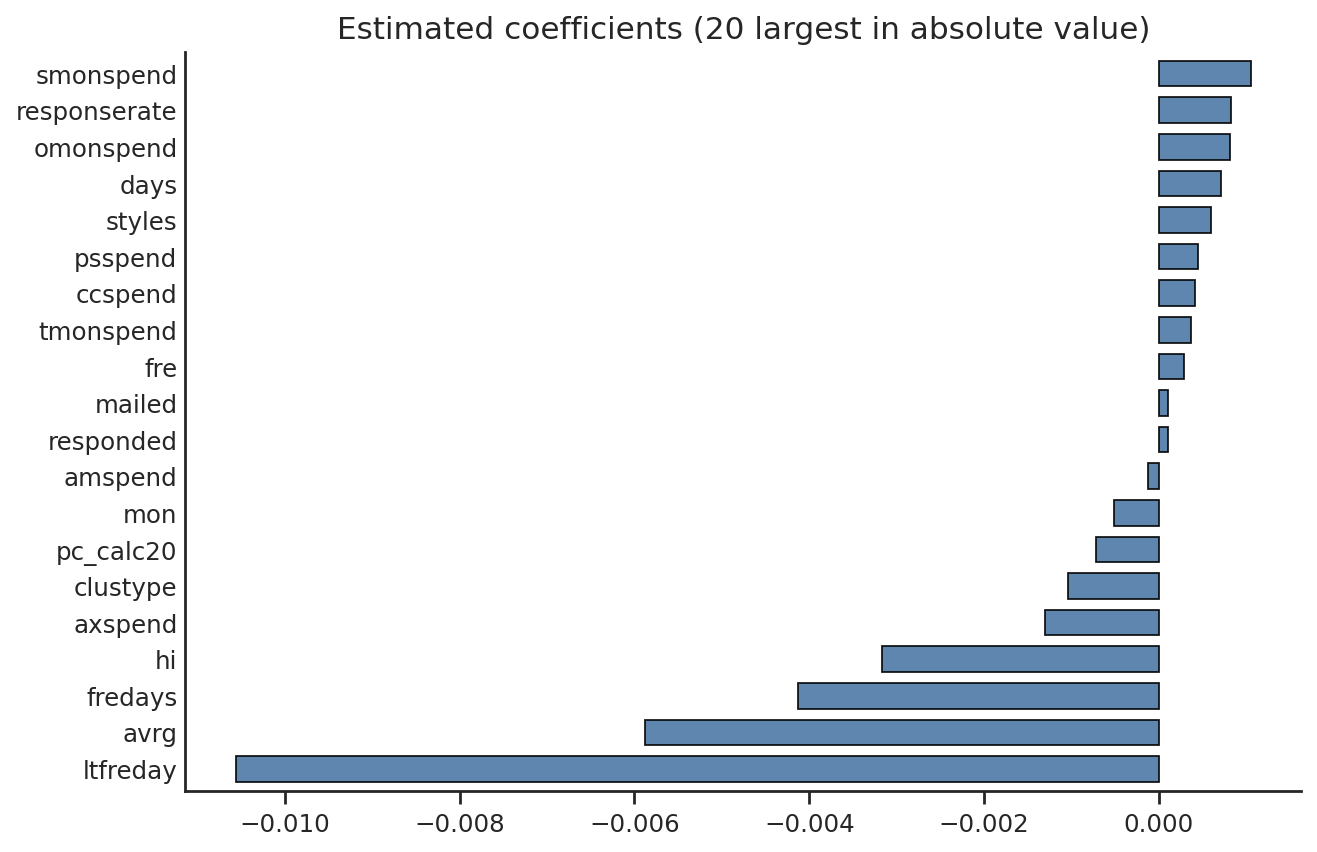

In [15]:
from tutorial2 import coefplot
coefplot(logit, predictors)
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegressionCV

# Select the penalties by cross-validation
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, scoring='neg_log_loss')

In [17]:
#Using newton-cg
from sklearn.linear_model import LogisticRegression

# Create a logistic regression object and set the solver hyperparameter to 'newton-cg'
logit3 = LogisticRegression(solver='newton-cg')

# Train the model on the training data
logit3.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit.predict(X_test)

In [18]:
logit3.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [19]:
#Using Solver
from sklearn.linear_model import LogisticRegression

# Create a logistic regression object and set the solver hyperparameter to 'lbfgs'
logit4 = LogisticRegression(solver='saga')

# Train the model on the training data
logit4.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit.predict(X_test)

logit4.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [20]:
#Using Solver
from sklearn.linear_model import LogisticRegression

# Create a logistic regression object and set the solver hyperparameter to 'lbfgs'
logit8 = LogisticRegression(solver='sag')

# Train the model on the training data
logit8.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit.predict(X_test)

logit8.fit(X_train, y_train)

LogisticRegression(solver='sag')

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [22]:
# Define the hyperparameter grid to search over
#param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}


In [ ]:
#grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
#grid_search.fit(X_train, y_train)

In [ ]:
# Get the best hyperparameters and score
#best_params = grid_search.best_params_
#best_score = grid_search.best_score_

In [ ]:

# Train the model with the best hyperparameters
#logit5 = LogisticRegression(**best_params)
#logit5.fit(X_train, y_train)

In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic regression', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Logistic newton-cg', 'Logistic Sag']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logreg, logit_l2, logit3, logit8]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(X_valid)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  9*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])

results.round(3)

,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic regression,0.612,0.024,0.874,0.497,0.265,0.800,0.370
Logistic $\ell_1$,0.455,0.019,0.929,0.583,0.316,0.855,0.329
Logistic $\ell_2$,0.464,0.020,0.925,0.579,0.313,0.854,0.332
Logistic newton-cg,0.462,0.020,0.923,0.586,0.316,0.853,0.330
Logistic Sag,0.656,0.020,0.923,0.351,0.228,0.765,0.392


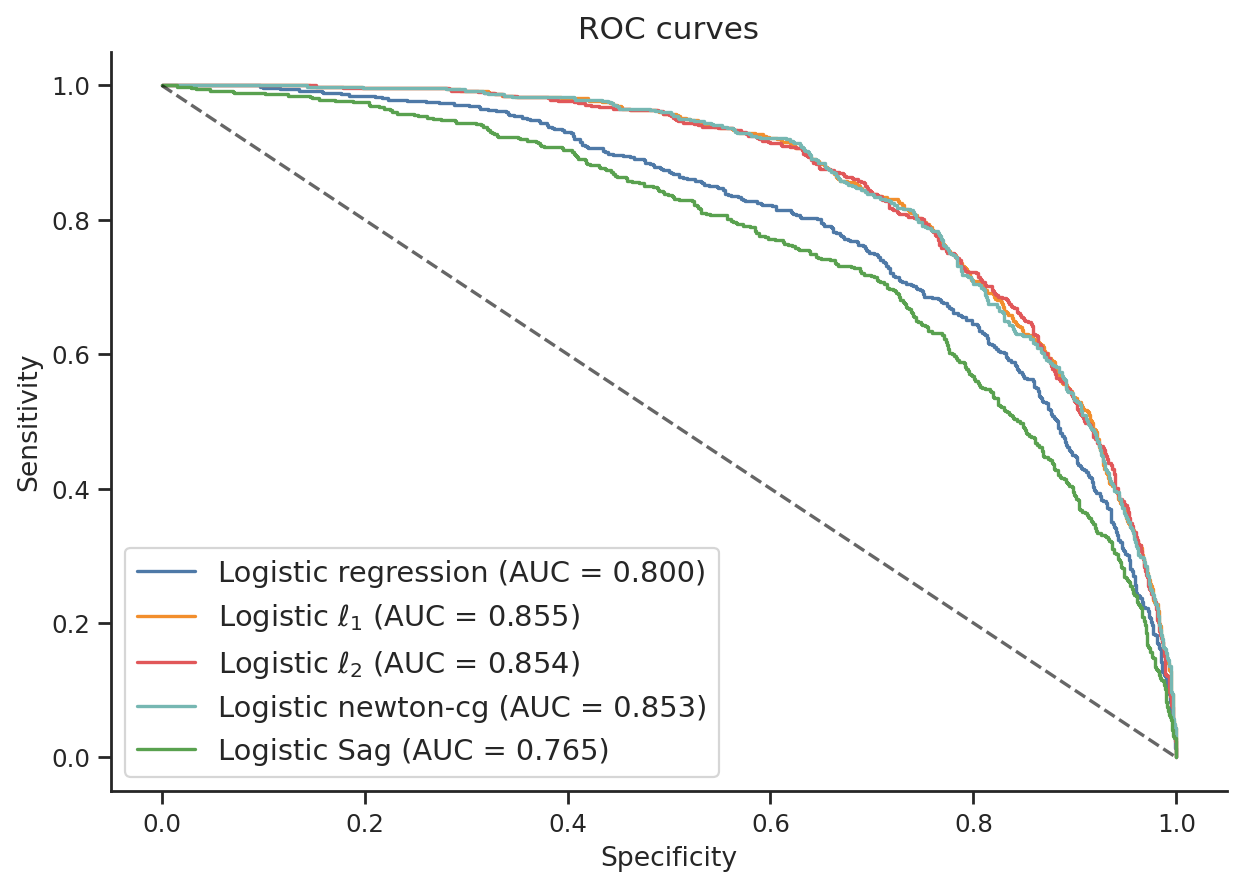

In [24]:
from tutorial2 import rocplot # higher AUC, the better
fig, ax = rocplot(y_valid, y_prob, labels=pd.Series(rows))
plt.show()



```
`[# This is formatted as code](https:// [link text](https://))`
```

# Lasso Selection

In [ ]:
from sklearn.linear_model import Lasso
import statsmodels.api as sm
## Implement Lasso
lassomodel = Lasso(alpha=0.01)
model = lassomodel.fit(X_train,y_train)
print(model.coef_)

[-0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.05182581 -0.
  0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.          0.          0.
 -0.         -0.00033076  0.          0.          0.00382893  0.
 -0.00131814 -0.        ]


In [ ]:
## Use the coefficients to show the variables used
Xlasso = X_train.iloc[:,lassomodel.coef_ != 0]
Xlasso.head()

,month_may,pdays,cons_conf_idx,nr_employed
17211,0,999,-36.1,5228.1
158,1,999,-36.4,5191.0
30440,1,11,-46.2,5099.1
13445,0,999,-42.7,5228.1
8538,0,999,-41.8,5228.1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load and preprocess the data
iris = load_iris()
X, y = iris.data, iris.target
X = StandardScaler().fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model with Lasso regularization
logreg2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)

# Fit the model on the training data
logreg2.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = logreg2.score(X_test, y_test)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.9333333333333333


In [ ]:
logreg2.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [ ]:
logreg2.fit(X_valid, y_valid)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss

columns=['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Lasso Log Regression']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logreg2]

y_valid = np.ravel(y_valid)
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(X_valid)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  9*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*9)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(y_valid))
    results.iloc[i,2] =  tp/(tp+fn)
    results.iloc[i,3] =  tn/(tn+fp)
    results.iloc[i,4] =  precision_score(y_valid, y_pred)
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,i])

results.sort_values(by=['Precision'], ascending = [0]).round(3)
results.round(3)

,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Lasso Log Regression,0.578,0.025,0.656,0.78,0.297,0.777,0.301




```
# This is formatted as code
```

# Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)

# Train the model on the training data
elastic_net.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, log_loss
import pandas as pd
import numpy as np

columns = ['Loss', 'SE', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows = ['Elastic Net']

results = pd.DataFrame(0.0, columns=columns, index=rows)

methods = [elastic_net]  # elastic_net is your ElasticNet model

y_valid = np.ravel(y_valid)
y_scores = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    y_pred = (y_prob[:,i] > tau).astype(int)
    y_scores[:, i] = y_pred  # Use predicted values as "scores"

    loss = 9 * ((y_pred != y_valid) & (y_pred == 0)) + 1 * ((y_pred != y_valid) & (y_pred == 1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

    results.iloc[i, 0] = np.mean(loss)  # or (fp*1+fn*9)/len(y_test)
    results.iloc[i, 1] = np.std(loss) / np.sqrt(len(y_valid))
    results.iloc[i, 2] = tp / (tp + fn)
    results.iloc[i, 3] = tn / (tn + fp)
    results.iloc[i, 4] = precision_score(y_valid, y_pred)
    results.iloc[i, 5] = roc_auc_score(y_valid, y_scores[:, i])
    results.iloc[i, 6] = log_loss(y_valid, y_scores[:, i])

results.sort_values(by=['Precision'], ascending=[0]).round(3)
results.round(3)



,Loss,SE,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Elastic Net,0.578,0.025,0.656,0.78,0.297,0.718,8.494
